# Определение возраста по лицу, проект Яндекс.Практикум

Датасет [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/)

Colab: https://colab.research.google.com/drive/1l_FjH-5upfIPUiohLxVVvRoJSQxAI4GP

## Исследование данных

Подключим все необходимые библиотеки и посмотрим на состав датасета.

In [0]:
!pip -q install face_recognition

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import os
import glob
from tqdm import tqdm
import requests
import zipfile
import json

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import face_recognition

SEED = 21
PATH = '/content/drive/My Drive/Colab Notebooks/data/'

Загрузим и распакуем датасет

In [0]:
if not os.path.exists('appa-real-release'):
    if not os.path.exists('appa-real-release.zip'):
        !wget -q http://158.109.8.102/AppaRealAge/appa-real-release.zip
    !unzip -q -u appa-real-release.zip

In [0]:
'''
def download_file(url, local_filename):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in tqdm(r.iter_content(chunk_size=10*1024*1024)): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return local_filename

if not os.path.exists(os.path.join(PATH, 'appa-real-release.zip')):
    download_file('http://158.109.8.102/AppaRealAge/appa-real-release.zip',
                  os.path.join(PATH, 'appa-real-release.zip'))
'''

"\ndef download_file(url, local_filename):\n    local_filename = url.split('/')[-1]\n    # NOTE the stream=True parameter below\n    with requests.get(url, stream=True) as r:\n        r.raise_for_status()\n        with open(local_filename, 'wb') as f:\n            for chunk in tqdm(r.iter_content(chunk_size=10*1024*1024)): \n                if chunk: # filter out keep-alive new chunks\n                    f.write(chunk)\n                    # f.flush()\n    return local_filename\n\nif not os.path.exists(os.path.join(PATH, 'appa-real-release.zip')):\n    download_file('http://158.109.8.102/AppaRealAge/appa-real-release.zip',\n                  os.path.join(PATH, 'appa-real-release.zip'))\n"

In [0]:
train_df = pd.read_csv('appa-real-release/gt_avg_train.csv')
valid_df = pd.read_csv('appa-real-release/gt_avg_valid.csv')

In [0]:
train_df.sample(3)

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
2097,002097.jpg,12,48.500000,4.602371,50
1600,001600.jpg,13,26.230769,2.681848,29
3952,003952.jpg,14,27.785714,3.724732,24


Посмотрим распределение возраста

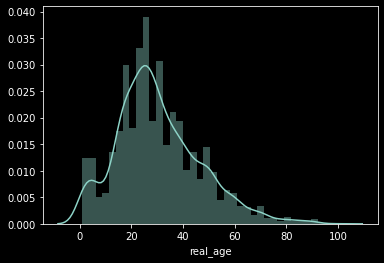

In [0]:
plt.style.use("dark_background")
sns.distplot(train_df['real_age'])

Выберем 15 фото из обучающей выборке и посмотрим на них

In [0]:
def plot_image_grid(path: str, labels, grid_shape, rectangles=None):    

    if grid_shape[0] * grid_shape[1] != len(labels):
        raise ValueError('Grid size must be equal to labels lenght')
    
    fig, axs = plt.subplots(*grid_shape, figsize=(12, 10), constrained_layout=True)    

    for i, col in enumerate(axs):
        for j,row in enumerate(col):
            data = labels.iloc[i*grid_shape[1]+j]
            fname = path + data['file_name']
            with Image.open(fname) as im:
                row.imshow(im)
            row.set_title('Real age: ' + str(data['real_age']))

            if rectangles:
                top, right, bottom, left = rectangles[i*grid_shape[1]+j]
                rect = Rectangle((left, top), right-left, bottom-top, fill=False, color='red')
                row.add_patch(rect)

    plt.show()

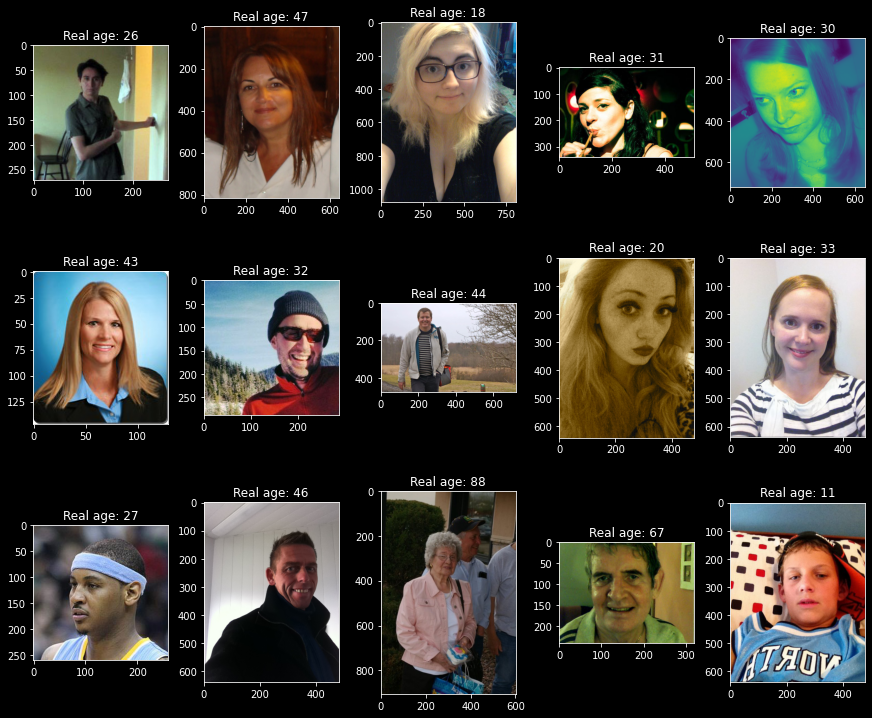

In [0]:
samples = train_df.sample(15, random_state=SEED)
plot_image_grid('appa-real-release/train/', samples, (3, 5))

## Определение лица и обрезка

Как мы видим все изображения разного размера и лицо занимает на них разную площадь.

Попробуем распознать лицо и обрезать фото по нему и привести к одному размеру



In [0]:
def add_face(row, path: str, l):
    fname = path + row['file_name']
    with Image.open(fname) as im:
        face_loc = face_recognition.face_locations(np.asarray(im))#, model='cnn')
    if len(face_loc) > 0:
        row['face_loc'] = face_loc[0]
    else:
        row['face_loc'] = (0, 0, 0, 0)
    return row

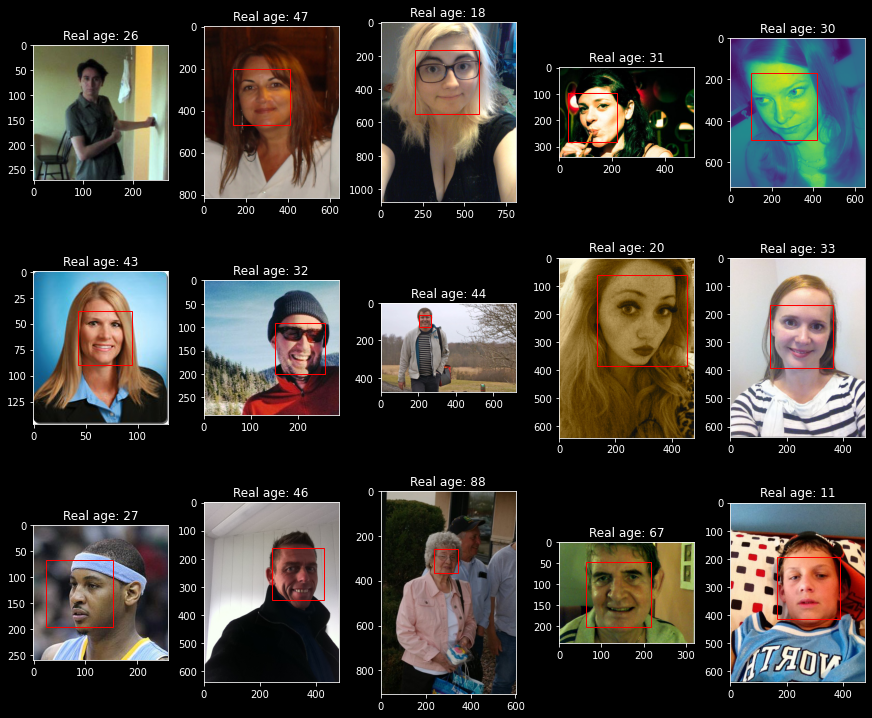

In [0]:
samples = samples.apply(add_face, axis=1, args=("appa-real-release/train/", 1))
plot_image_grid('appa-real-release/train/', samples, (3, 5), rectangles=samples['face_loc'].to_list())

Видно что не захватывается верхняя часть головы. Прибавим к рамкам по 10% скаждой стороны и 50% сверху.

Обрежем изображения по новой рамке и приведем к единому размеру 100x150 px

In [0]:
def crop_and_save(df, path, postfix='_crop'):
    if path[-1] == '/':
        path = path[: -1]

    if not os.path.exists(path + postfix +'/'):
        os.mkdir(path + postfix +'/')
        
    for fname, face in tqdm(zip(df['file_name'], df['face_loc'])):
        file_path = path + '/' + fname
        with Image.open(file_path) as im:
            top, right, bottom, left = face
            width = right - left
            height = bottom - top
            box = (int(left - width * 0.1),
                   int(top - height * 0.5),
                   int(right + width * 0.1),
                   int(bottom + height * 0.2))
            im = im.crop(box)
            im = im.resize((100, 150))
            im.save(path + postfix + '/' + fname)

15it [00:00, 101.43it/s]


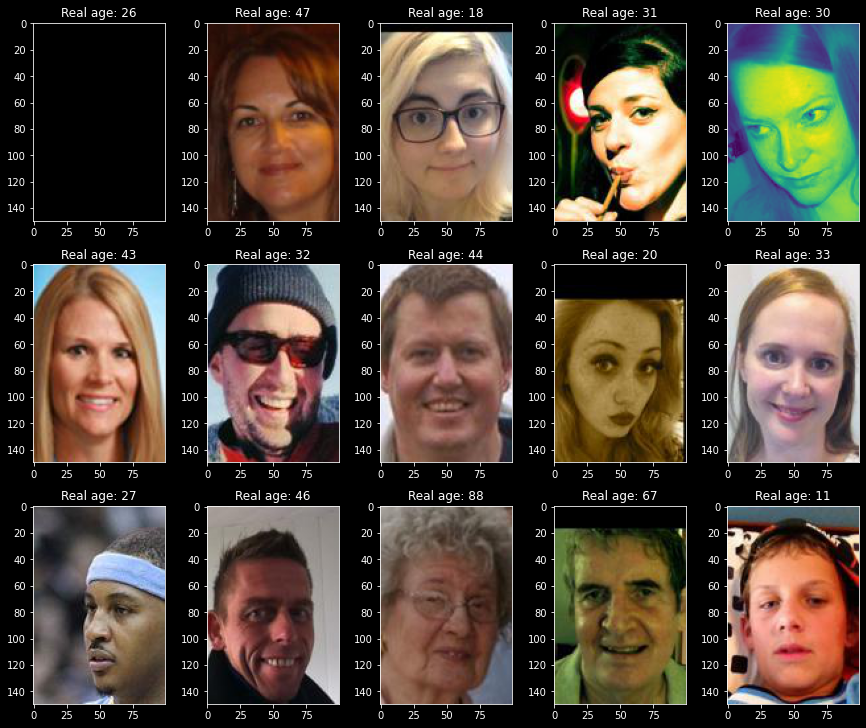

In [0]:
crop_and_save(samples, 'appa-real-release/train/')
plot_image_grid('appa-real-release/train_crop/', samples, (3, 5))

Как мы видим на 15 изображениях все отработало почти корректно, не определилось одно лицо



## Обработка всего датасета
Найдем лица на всем датасете

In [0]:
tqdm.pandas()
train_df = train_df.progress_apply(add_face, axis=1, args=("appa-real-release/train/", 1))
valid_df = valid_df.progress_apply(add_face, axis=1, args=("appa-real-release/valid/", 1))

 14%|█▍        | 579/4113 [03:37<17:07,  3.44it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 61%|██████    | 908/1500 [04:25<02:20,  4.22it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibl

Сохраним файлы в папку с постфиксом _crop

In [0]:
crop_and_save(train_df, 'appa-real-release/train/')
crop_and_save(valid_df, 'appa-real-release/valid/')

564it [00:05, 128.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
4113it [00:40, 102.73it/s]
906it [00:07, 127.19it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  E

Выкинем из обучающей выборки не определенные лица

In [0]:
train_df = train_df[train_df['face_loc'] != (0, 0, 0, 0)]

## Обучение модели

1. Загрузим данные:
    1. Размер батча 256 - подобран опытным путем, что бы хватало памяти GPU
    1. Для обучаюшей выборке применим аугментацию vertical_flip
1. Примени модель ResNet50 добавив сверху полносвязный слой с Relu активацией. Веса imagenet использовать не будем, так как там задача классификации
1. Обучим модель на 100 эпохах и посмотрим кривые обучения

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, vertical_flip=True)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='appa-real-release/train_crop/',
        x_col='file_name',
        y_col='real_age',
        target_size=(100, 150),
        batch_size=256,
        class_mode='raw')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='appa-real-release/valid_crop/',
        x_col='file_name',
        y_col='real_age',
        target_size=(100, 150),
        batch_size=256,
        class_mode='raw')

Found 3823 validated image filenames.
Found 1500 validated image filenames.


In [0]:
def create_model():
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights=None,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    return model

In [0]:
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#strategy = tf.distribute.experimental.TPUStrategy(resolver)


with tf.device('/device:GPU:0'):
    model = create_model()
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [0]:
with tf.device('/device:GPU:0'):
    history = model.fit(
            train_gen_flow,
            epochs=100,
            steps_per_epoch=len(train_gen_flow),
            validation_data=valid_gen_flow,
            validation_steps=len(valid_gen_flow))

Epoch 1/100
15/15 [==============================] - 9s 621ms/step - loss: 588.1825 - mae: 18.8801 - val_loss: 1205.5625 - val_mae: 30.6053
Epoch 2/100
15/15 [==============================] - 8s 510ms/step - loss: 274.1381 - mae: 12.9182 - val_loss: 1192.6945 - val_mae: 30.5149
Epoch 3/100
15/15 [==============================] - 8s 508ms/step - loss: 248.6258 - mae: 12.2923 - val_loss: 741.6505 - val_mae: 22.7397
Epoch 4/100
15/15 [==============================] - 8s 509ms/step - loss: 228.7196 - mae: 11.8156 - val_loss: 798.1516 - val_mae: 23.6687
Epoch 5/100
15/15 [==============================] - 8s 512ms/step - loss: 203.3420 - mae: 11.1037 - val_loss: 657.9468 - val_mae: 21.2832
Epoch 6/100
15/15 [==============================] - 8s 515ms/step - loss: 187.6616 - mae: 10.7326 - val_loss: 410.5621 - val_mae: 15.5623
Epoch 7/100
15/15 [==============================] - 8s 508ms/step - loss: 175.7687 - mae: 10.4043 - val_loss: 556.6430 - val_mae: 18.8492
Epoch 8/100
15/15 [======

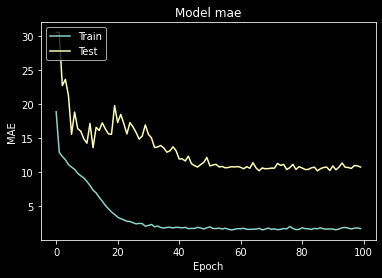

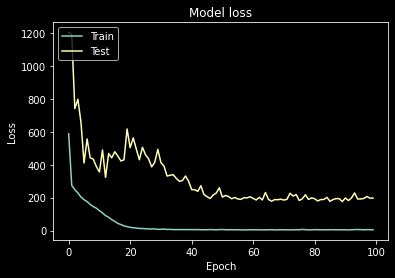

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Как видно из графиков loss и метрика выходят на асимптоту после ~50 эпох.

MAE на валидационной выборке ~10

Сохраним модель на всякий случай на гугл диск

In [0]:
model.reset_metrics()
model.save(os.path.join(PATH, 'model.h5'))

## Другой датасет
У нас не получилось досчить MAE меньше чем 8.

Попробуем ипользовать другой датасет с уже обрезанными лицами с Kaggle
https://www.kaggle.com/abhikjha/appa-real-face-cropped

Для начала загрузим его

In [0]:
if os.path.exists(os.path.join(PATH, 'kaggle.json')):
    os.environ['KAGGLE_CONFIG_DIR'] = PATH
else: 
    raise FileNotFoundError

In [0]:
!kaggle datasets download -d abhikjha/appa-real-face-cropped

appa-real-face-cropped.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip -q -u -d appa-real-face-cropped/ appa-real-face-cropped.zip

In [0]:
labels = pd.read_csv('appa-real-face-cropped/labels.csv')
labels.sample(15, random_state=SEED).head(3)

,file_name,real_age
4296,004296.jpg,1
7133,007149.jpg,16
3102,003102.jpg,56


Попробуем найти те лица которые были в исходном датасете

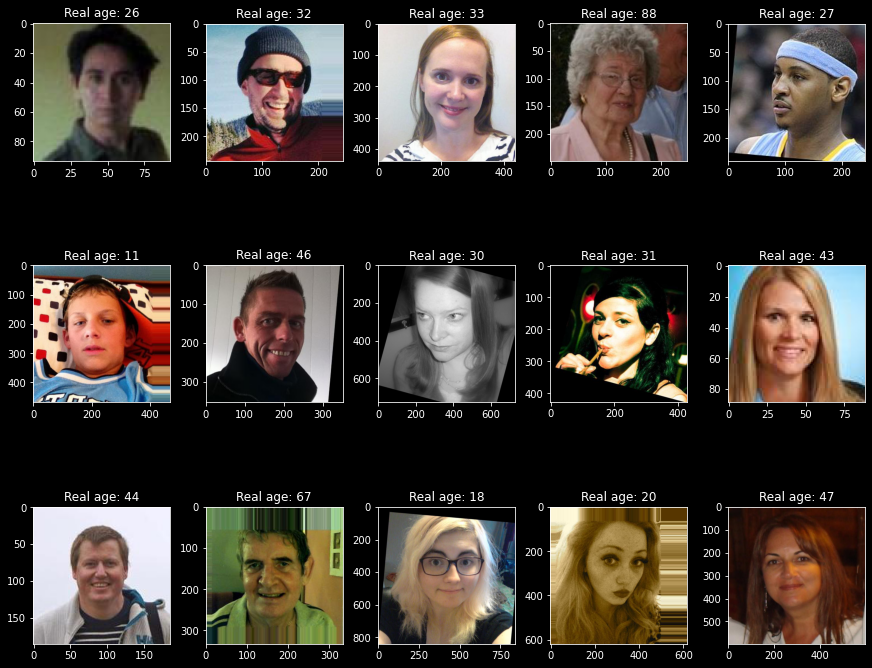

In [0]:
assert labels['file_name'].isin(samples['file_name']).sum() == samples.shape[0]
plot_image_grid('appa-real-face-cropped/final_files/final_files/',
                labels[labels['file_name'].isin(samples['file_name'])],
                grid_shape=(3, 5))

Отлично, визуально лица совпадают.

Видно что автор датасета провел более тщательную обработку чем я.

Картинки по прежнему разного размера, но у них одинаковое соотношение сторон.

Загрузим датасет в keras и попробуем заново обучить модель. Размер изображения укажем как 224х224

Для валидации вывделим 30% датасета, размер батча  128, так как увеличилась картинка и 256 уже не помещается в память

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, vertical_flip=True, validation_split=0.3)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='appa-real-face-cropped/final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=128, 
        subset='training',
        class_mode='raw',
        seed=SEED)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
valid_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='appa-real-face-cropped/final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=128,
        subset='validation',
        class_mode='raw',
        seed=SEED)

Found 5314 validated image filenames.
Found 450 validated image filenames.


In [0]:
with tf.device('/device:GPU:0'):
    model = create_model()
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [0]:
with tf.device('/device:GPU:0'):
    history = model.fit(
            train_gen_flow,
            epochs=40,
            steps_per_epoch=len(train_gen_flow),
            validation_data=valid_gen_flow,
            validation_steps=len(valid_gen_flow))

Epoch 1/40
42/42 [==============================] - 32s 757ms/step - loss: 368.4629 - mae: 14.7302 - val_loss: 1033.9065 - val_mae: 27.2737
Epoch 2/40
42/42 [==============================] - 31s 732ms/step - loss: 290.8282 - mae: 13.1728 - val_loss: 778.1830 - val_mae: 22.6465
Epoch 3/40
42/42 [==============================] - 31s 728ms/step - loss: 270.8383 - mae: 12.6935 - val_loss: 547.3812 - val_mae: 17.6986
Epoch 4/40
42/42 [==============================] - 31s 734ms/step - loss: 261.0829 - mae: 12.4791 - val_loss: 350.3339 - val_mae: 14.3971
Epoch 5/40
42/42 [==============================] - 31s 730ms/step - loss: 254.8712 - mae: 12.2838 - val_loss: 318.7945 - val_mae: 13.5097
Epoch 6/40
42/42 [==============================] - 31s 736ms/step - loss: 258.2948 - mae: 12.3663 - val_loss: 352.3668 - val_mae: 14.3251
Epoch 7/40
42/42 [==============================] - 31s 729ms/step - loss: 239.8884 - mae: 11.8748 - val_loss: 294.7574 - val_mae: 12.7432
Epoch 8/40
42/42 [========

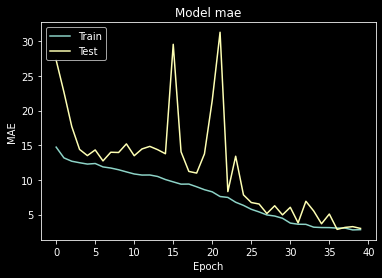

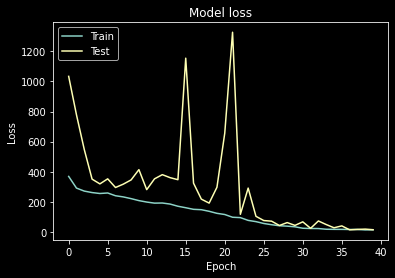

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

MAE ниже 8 достигнут на эпохе 25

Вообще выглядит как переобучение, так как датасет достаточно мал и мала валидационная выборка

Веселья ради, проверим модель на моей фотографии и фотографии наставника =)
Если что, мне 27 =)

In [0]:
yan = Image.open(os.path.join(PATH, 'Yan.jpg')).resize((224, 224))
ivan = Image.open(os.path.join(PATH, 'Ivan.jpg')).resize((224, 224))

yan_numpy = np.asarray(yan)
ivan_numpy = np.asarray(ivan)

test = np.array([yan_numpy, ivan_numpy])
predict = model.predict(test)
predict

array([[6718.7617],
       [4859.6978]], dtype=float32)

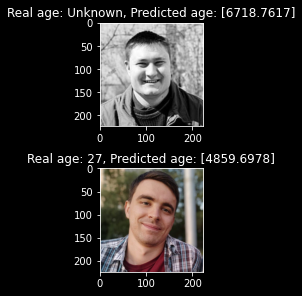

In [0]:
fig, axs = plt.subplots(2, constrained_layout=True)
axs[0].imshow(yan)
axs[0].set_title('Real age: {}, Predicted age: {}'.format('Unknown', predict[0]))
axs[1].imshow(ivan)
axs[1].set_title('Real age: {}, Predicted age: {}'.format(27, predict[1]))
plt.show()